In [1]:
from torch.utils.data import DataLoader
from dataset import NERDataset


def collate_fn(batch):
    return tuple(zip(*batch))


train_data = NERDataset('data\\train')
test_data = NERDataset('data\\test')

train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=collate_fn)

In [2]:
from utils import word_to_ix
word_to_ix = word_to_ix([train_data, test_data])
word_to_ix

{'УТВЕРЖДЕНИИ': 0,
 'РАЗВИТИЯ': 1,
 'Принят': 2,
 'Утвердить': 3,
 'развития': 4,
 'вступает в силу': 5,
 'утверждении': 6,
 'входит в состав': 7,
 'Площадь территории края': 8,
 'составляет': 9,
 'территории России': 10,
 'Средне годовая численность населения края': 11,
 'составила': 12,
 'населения России': 13,
 'численность занятых в экономике': 14,
 'общего числа занятых в экономике страны': 15,
 'высокая': 16,
 'доля сельского населения': 17,
 'плотности населения': 18,
 'занимает': 19,
 'лидирующее': 20,
 'положение в округе': 21,
 'в два раза выше': 22,
 'Средняя плотность населения': 23,
 'Высокая': 24,
 'концентрация численности населения': 25,
 'отмечается': 26,
 'проживают': 27,
 'населения края': 28,
 'Плотность населения': 29,
 'муниципальных районах': 30,
 'административный состав края': 31,
 'входят': 32,
 'городских округов': 33,
 'муниципальных районов': 34,
 'сельских поселений': 35,
 'Современное гео экономическое положение Алтайского края': 36,
 'определяется': 37,


In [3]:
tag_to_ix = train_data.tag_to_ix()
tag_to_ix

{'MET': 0,
 'SOC': 1,
 'QUA': 2,
 'ECO': 3,
 'BIN': 4,
 'INST': 5,
 'CMP': 6,
 'ACT': 7,
 '<START>': 8,
 '<STOP>': 9}

In [4]:
next(iter(train_loader))

((('муниципального образования',
   'муниципального образования',
   'разработан',
   'стратегическом планировании',
   'стратегических целей',
   'сформулированных',
   'посланиях Президента Российской Федерации',
   'Федеральному Собранию Российской Федерации',
   'указах Президента Российской Федерации',
   'стратегии развития Оренбургской области',
   'стратегии развития',
   'муниципального образования',
   'инструментов управления финансами',
   'выступает',
   'планирование',
   'регламентированный ( упорядоченный ) процесс',
   'связь с обработкой информации',
   'направленность',
   'достижение',
   'Перспективное финансовое планирование',
   'осуществляется',
   'обеспечения',
   'координации',
   'экономического',
   'социального',
   'развития',
   'финансовой политики',
   'комплексного',
   'прогнозирования',
   'финансовых последствий',
   'разрабатываемых',
   'реформ',
   'программ',
   'решений',
   'отслеживания',
   'долго  срочных',
   'негативных',
   'тенденций',

In [5]:
from model import BiLSTM_CRF

EMBEDDING_DIM = 5
HIDDEN_DIM = 4

bilstm = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

In [18]:
from torch import optim
import torch
from lab3.utils import prepare_sequence
from tqdm import tqdm
from sklearn.metrics import f1_score

optimizer = optim.Adam(bilstm.parameters(), lr=0.01, weight_decay=1e-4)

def train_one_epoch(model: torch.nn.Module, train_dataloader, epoch: int):
    epoch_loss = 0
    with tqdm(total=len(train_dataloader)) as t1:
        for i, data in enumerate(train_dataloader):
            sentence, tags = data
            sentence, tags = sentence[0], tags[0]
            bilstm.zero_grad()

            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

            loss = model.neg_log_likelihood(sentence_in, targets)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
            t1.set_description_str(f'Epoch: {epoch + 1}')
            t1.set_postfix_str(f'Loss: {epoch_loss / (i + 1)}')
            t1.update(1)
    return epoch_loss / (len(train_dataloader))


def test_one_epoch(model: torch.nn.Module, test_dataloader, epoch: int):
    f1 = 0
    with torch.no_grad(), tqdm(total=len(test_dataloader)) as t2:
        for i, data in enumerate(test_dataloader):
            sentence, tags = data
            sentence, tags = sentence[0], tags[0]
            precheck_sent = prepare_sequence(sentence, word_to_ix)
            f1 += f1_score(model(precheck_sent)[1], [tag_to_ix[t] for t in tags], average='micro')
            t2.set_description_str(f'Epoch: {epoch + 1}')
            t2.set_postfix_str(f'Accuracy: {f1 / (i + 1)}')
            t2.update(1)
    return f1 / len(test_dataloader)


def train(model: torch.nn.Module, train_dataloader, test_dataloader, epochs: int = 10):
    best_weights = model.state_dict()
    losses = list()
    f1_scores = list()
    best_score = 0
    for i in range(epochs):
        losses.append(train_one_epoch(model, train_dataloader, i))
        f1_scores.append(test_one_epoch(model, test_dataloader, i))

        if f1_scores[-1] > best_score:
            best_weights = model.state_dict()
            best_score = f1_scores[-1]

    return best_weights, losses, f1_scores

In [19]:
best_weights, losses, f1_scores = train(bilstm, train_loader, test_loader, 10)

Epoch: 10: 100%|██████████| 30/30 [00:02<00:00, 10.56it/s, Accuracy: 0.5802338225593152]


In [20]:
bilstm.load_state_dict(best_weights)
test_one_epoch(bilstm, test_loader, epoch=0)

Epoch: 1: 100%|██████████| 30/30 [00:03<00:00,  9.90it/s, Accuracy: 0.5886323639497262]


0.5886323639497262

Text(0, 0.5, 'Loss')

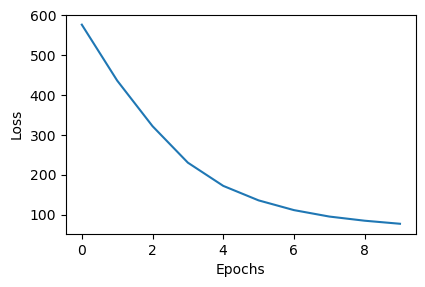

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(list(range(len(losses))), losses)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Text(0, 0.5, 'F1 score')

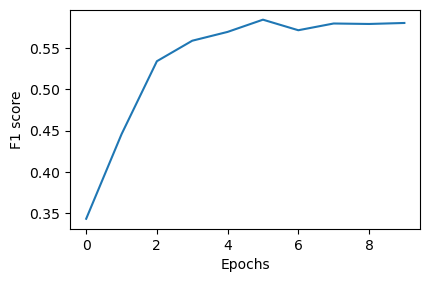

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(list(range(len(losses))), f1_scores)
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 score')